## Section 1: Setup & Data Loading

This section loads all dependencies, configures the environment, and prepares the models and data for analysis.

## Section 1: Setup & Data Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import sys
import joblib
import random

import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

# Add modules to path
sys.path.append(str(Path.cwd() / 'modules'))
from modules.feature_extraction import extract_all_features_enhanced
from modules.snn_models import *

# Paths
BASE_DIR = Path.cwd()
RESULTS_DIR = BASE_DIR / 'results' / 'snn'
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

✓ Environment configured (device: cpu)


In [36]:
# Load feature configuration
with open(RESULTS_DIR / 'optimal_feature_config_comprehensive.json', 'r') as f:
    feature_config = json.load(f)

feature_names = feature_config.get('feature_names', [f"feature_{i}" for i in feature_config['selected_indices']])
n_features = len(feature_config['selected_indices'])

# Create short labels for plots (e.g., 'θ12' for theta_12)
band_symbols = {'delta': 'δ', 'theta': 'θ', 'alpha': 'α', 'beta': 'β', 'gamma': 'γ'}
feature_labels = []
for fname in feature_names:
    label = fname
    for band, symbol in band_symbols.items():
        if band in fname.lower():
            num = ''.join(filter(str.isdigit, fname))
            label = f"{symbol}{num}" if num else symbol
            break
    if 'entropy' in fname.lower():
        label = 'entropy'
    feature_labels.append(label)

# Load baseline model
baseline_model = SNN(num_features=n_features, num_classes=2, num_steps=35, 
                     hidden1_size=56, hidden2_size=42, dropout=0.4)
baseline_model.load_state_dict(torch.load(RESULTS_DIR / 'two_layer_28features_model.pth', map_location=device))
baseline_model.to(device)
baseline_model.eval()

print(f"Loaded {n_features} features")

Loaded 28 features


In [37]:
# Load data splits
train_data = joblib.load(PROCESSED_DIR / 'train_data.pkl')
val_data = joblib.load(PROCESSED_DIR / 'val_data.pkl')
test_data = joblib.load(PROCESSED_DIR / 'test_data.pkl')

# Get test patient IDs by label
test_patient_ids = list(set([seg.patient_id for seg in test_data]))
pd_patients = [pid for pid in test_patient_ids if any(seg.label == 1 for seg in test_data if seg.patient_id == pid)]
control_patients = [pid for pid in test_patient_ids if any(seg.label == 0 for seg in test_data if seg.patient_id == pid)]

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)} segments")
print(f"Test patients - PD: {len(pd_patients)}, Control: {len(control_patients)}")

Train: 384, Val: 120, Test: 156 segments
Test patients - PD: 7, Control: 6


## Patient Selection

In [38]:
# Select 1 PD + 1 Control patient
random.seed(RANDOM_SEED)
selected_pd = random.sample(pd_patients, 1)[0]
selected_control = random.sample(control_patients, 1)[0]
selected_subjects = [selected_pd, selected_control]

print(f"Selected: {selected_pd} (PD), {selected_control} (Control)")

# Extract and store features for selected subjects
subject_data = {}
for pid in selected_subjects:
    patient_segments = [seg for seg in test_data if seg.patient_id == pid]
    
    segment_features = []
    for seg in patient_segments:
        all_features, _ = extract_all_features_enhanced(seg.data)
        selected_features = all_features[feature_config['selected_indices']]
        segment_features.append(selected_features)
    
    features_array = np.array(segment_features)
    
    subject_data[pid] = {
        'features_all': features_array,
        'features_avg': features_array.mean(axis=0),
        'label': patient_segments[0].label,
        'n_segments': len(patient_segments)
    }

# Fit scaler on training data
train_features = []
for seg in train_data:
    all_features, _ = extract_all_features_enhanced(seg.data)
    train_features.append(all_features[feature_config['selected_indices']])
train_features = np.array(train_features)

scaler = StandardScaler()
scaler.fit(train_features)

# Apply scaling to selected subjects
for pid in selected_subjects:
    subject_data[pid]['features_avg_scaled'] = scaler.transform(
        subject_data[pid]['features_avg'].reshape(1, -1)
    )[0]

print("Feature extraction complete")

Selected: P01 (PD), C08 (Control)
Feature extraction complete


In [39]:
# Create hardware-aware model with memristor quantization
hardware_model = HardwareAwareSNN(
    baseline_snn=baseline_model,
    r_on=1000,      # 1 kΩ
    r_off=10000,    # 10 kΩ
    num_levels=256  # 8-bit
)
hardware_model.eval()

print(f"\nBaseline weights [0,0:5]: {baseline_model.fc1.weight.data[0, :5]}")
print(f"Hardware weights [0,0:5]: {hardware_model.snn.fc1.weight.data[0, :5]}")

  fc1       : Shape (56, 28), Quantization error = 0.000397
  fc2       : Shape (42, 56), Quantization error = 0.000319
  fc_out    : Shape (2, 42), Quantization error = 0.000350

Baseline weights [0,0:5]: tensor([-0.0567, -0.0170, -0.1030,  0.0410, -0.1560])
Hardware weights [0,0:5]: tensor([-0.0565, -0.0164, -0.1030,  0.0413, -0.1560])


In [ ]:
# Helper functions

def get_snn(model):
    """Get the underlying SNN from a model (handles HardwareAwareSNN wrapper)."""
    return model.snn if hasattr(model, 'snn') else model


def get_prediction_confidence(model, patient_features):
    """Get prediction and confidence from spike counts."""
    with torch.no_grad():
        x = torch.FloatTensor(patient_features).unsqueeze(0).to(device)
        spk_out, _ = model(x)
        spike_counts = spk_out.sum(dim=0)
        probs = torch.softmax(spike_counts, dim=1)[0]
        
        control_conf = probs[0].item() * 100
        pd_conf = probs[1].item() * 100
        predicted_class = 1 if pd_conf >= 50 else 0
        
        return predicted_class, control_conf, pd_conf


def calculate_feature_attribution(model, patient_features):
    """Calculate per-feature contribution (input * weight magnitude)."""
    snn = get_snn(model)
    with torch.no_grad():
        x = torch.FloatTensor(patient_features).to(device)
        weighted = snn.fc1.weight.data * x
        attribution = torch.abs(weighted).sum(dim=0).cpu().numpy()
        return (attribution / attribution.sum()) * 100


def calculate_band_importance(model, patient_features, feature_names):
    """Calculate importance by frequency band."""
    snn = get_snn(model)
    
    # Group features by band
    band_groups = {'delta': [], 'theta': [], 'alpha': [], 'beta': [], 'gamma': []}
    for idx, fname in enumerate(feature_names):
        for band in band_groups:
            if band in fname.lower():
                band_groups[band].append(idx)
                break
    
    # Calculate contribution per band
    band_importance = {}
    with torch.no_grad():
        for band, indices in band_groups.items():
            if indices:
                weights = snn.fc1.weight[:, indices]
                feats = torch.FloatTensor(patient_features[indices])
                band_importance[band] = torch.abs(weights @ feats).sum().item()
            else:
                band_importance[band] = 0
    
    # Normalize to percentages
    total = sum(band_importance.values())
    if total > 0:
        band_importance = {k: v / total * 100 for k, v in band_importance.items()}
    
    return band_importance


def calculate_neuron_firing(model, patient_features):
    """Count spikes per neuron across all timesteps."""
    snn = get_snn(model)
    l1_spikes, l2_spikes, out_spikes = [], [], []
    
    with torch.no_grad():
        x = torch.FloatTensor(patient_features).unsqueeze(0).to(device)
        mem1 = snn.lif1.init_leaky()
        mem2 = snn.lif2.init_leaky()
        mem_out = snn.lif_out.init_leaky()
        
        for _ in range(snn.num_steps):
            cur1 = snn.fc1(x)
            spk1, mem1 = snn.lif1(cur1, mem1)
            l1_spikes.append(spk1.cpu().numpy()[0])
            
            cur2 = snn.fc2(spk1)
            spk2, mem2 = snn.lif2(cur2, mem2)
            l2_spikes.append(spk2.cpu().numpy()[0])
            
            cur_out = snn.fc_out(spk2)
            spk_out, mem_out = snn.lif_out(cur_out, mem_out)
            out_spikes.append(spk_out.cpu().numpy()[0])
    
    return np.array(l1_spikes).sum(axis=0), np.array(l2_spikes).sum(axis=0), np.array(out_spikes).sum(axis=0)

def calculate_neuron_firing_strength(model, patient_features):
    """Calculate total firing strength per neuron over all timesteps"""
    # Handle both direct SNN and HardwareAwareSNN wrapper
    snn_model = model.snn if hasattr(model, 'snn') else model

    spike_history_L1 = []
    spike_history_L2 = []
    spike_history_out = []

    with torch.no_grad():
        x = torch.FloatTensor(patient_features).unsqueeze(0).to(device)
        mem1 = snn_model.lif1.init_leaky()
        mem2 = snn_model.lif2.init_leaky()
        mem_out = snn_model.lif_out.init_leaky()

        for step in range(snn_model.num_steps):  # Use model's num_steps
            # Layer 1
            cur1 = snn_model.fc1(x)
            spk1, mem1 = snn_model.lif1(cur1, mem1)
            spike_history_L1.append(spk1.cpu().numpy()[0])

            # Layer 2
            cur2 = snn_model.fc2(spk1)
            spk2, mem2 = snn_model.lif2(cur2, mem2)
            spike_history_L2.append(spk2.cpu().numpy()[0])

            # Output
            cur_out = snn_model.fc_out(spk2)
            spk_out, mem_out = snn_model.lif_out(cur_out, mem_out)
            spike_history_out.append(spk_out.cpu().numpy()[0])

In [68]:
def visualize_interpretability(
    baseline_model,
    hardware_model,
    patient_features,
    pid,
    device,
    RESULTS_DIR
):
    """
    Single-row (1x3) interpretability visualization:
    1) Layer 1 activations
    2) Activation differences per neuron
    3) Spike count comparison
    """

    # Create 1x2 layout
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(
        f'Patient {pid}: Baseline vs Hardware-Aware SNN Interpretability',
        fontsize=16,
        fontweight='bold'
    )

    # Prepare input
    with torch.no_grad():
        x = torch.FloatTensor(patient_features).unsqueeze(0).to(device)

        base_act = baseline_model.fc1(x).cpu().numpy()[0]

        hw_fc1 = (
            hardware_model.snn.fc1
            if hasattr(hardware_model, 'snn')
            else hardware_model.fc1
        )
        hw_act = hw_fc1(x).cpu().numpy()[0]

    neuron_idx = np.arange(len(base_act))

    # Plot 1: Layer 1 Activations
    ax0 = axes[0]
    ax0.scatter(neuron_idx, base_act, label='Baseline',
                alpha=0.7, s=30, color='blue')
    ax0.scatter(neuron_idx, hw_act, label='Hardware-Aware',
                alpha=0.7, s=30, color='red', marker='x')

    ax0.set_title('Layer 1 Activations', fontweight='bold')
    ax0.set_xlabel('Neuron Index', fontweight='bold')
    ax0.set_ylabel('Activation Value', fontweight='bold')
    ax0.legend()
    ax0.grid(alpha=0.3)

    # Plot 3: Spike Count Comparison
    ax2 = axes[1]
    base_spk, _, _ = calculate_neuron_firing_strength(
        baseline_model, patient_features
    )
    hw_spk, _, _ = calculate_neuron_firing_strength(
        hardware_model, patient_features
    )

    width = 0.35
    x_pos = np.arange(len(base_spk))

    ax2.bar(x_pos - width / 2, base_spk, width,
            label='Baseline', alpha=0.7, color='blue')
    ax2.bar(x_pos + width / 2, hw_spk, width,
            label='Hardware-Aware', alpha=0.7, color='red')

    ax2.set_title('Spike Count Comparison (Layer 1)', fontweight='bold')
    ax2.set_xlabel('Neuron Index', fontweight='bold')
    ax2.set_ylabel('Total Spikes (35 timesteps)', fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.90])

    # Save and show
    output_filename = f"{pid.lower()}_interpretability_1x3.png"
    plt.savefig(RESULTS_DIR / output_filename, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Saved interpretability figure: {output_filename}")



Patient 1/2: P01 (PD)


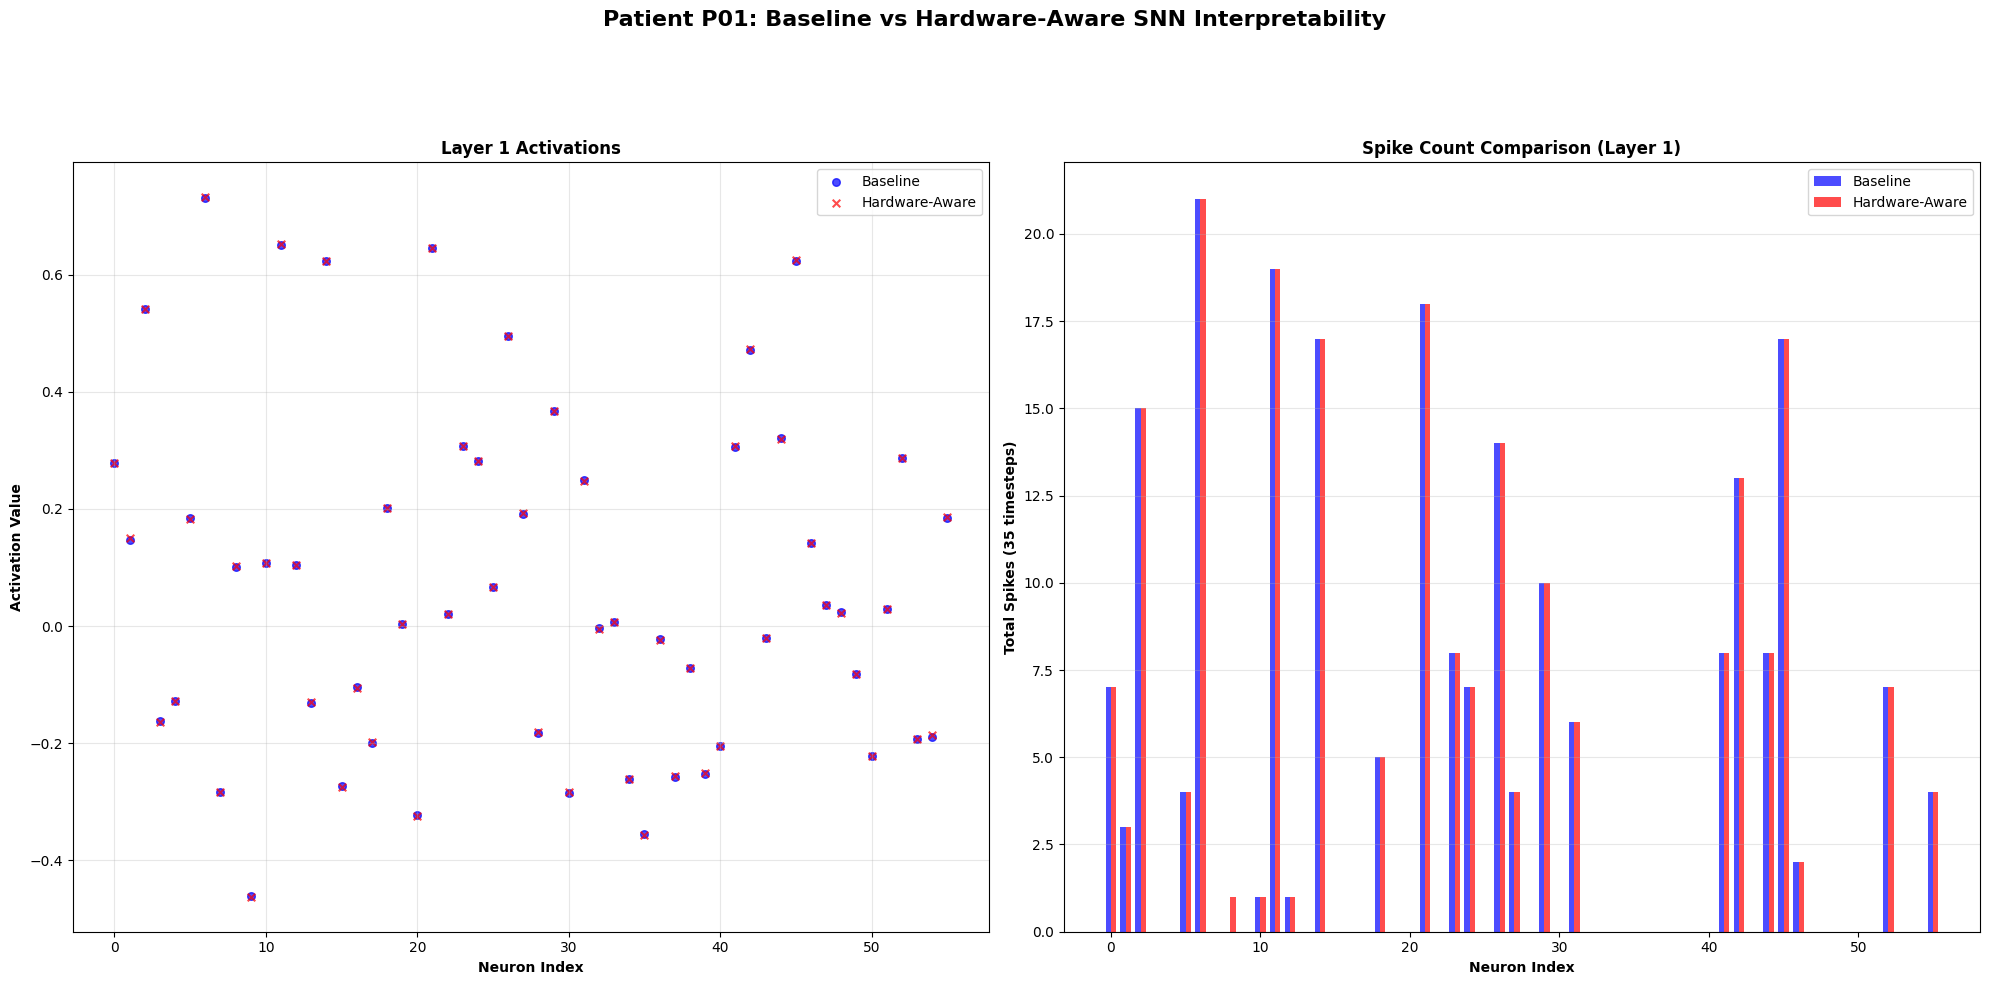

Saved interpretability figure: p01_interpretability_1x3.png

Patient 2/2: C08 (Control)


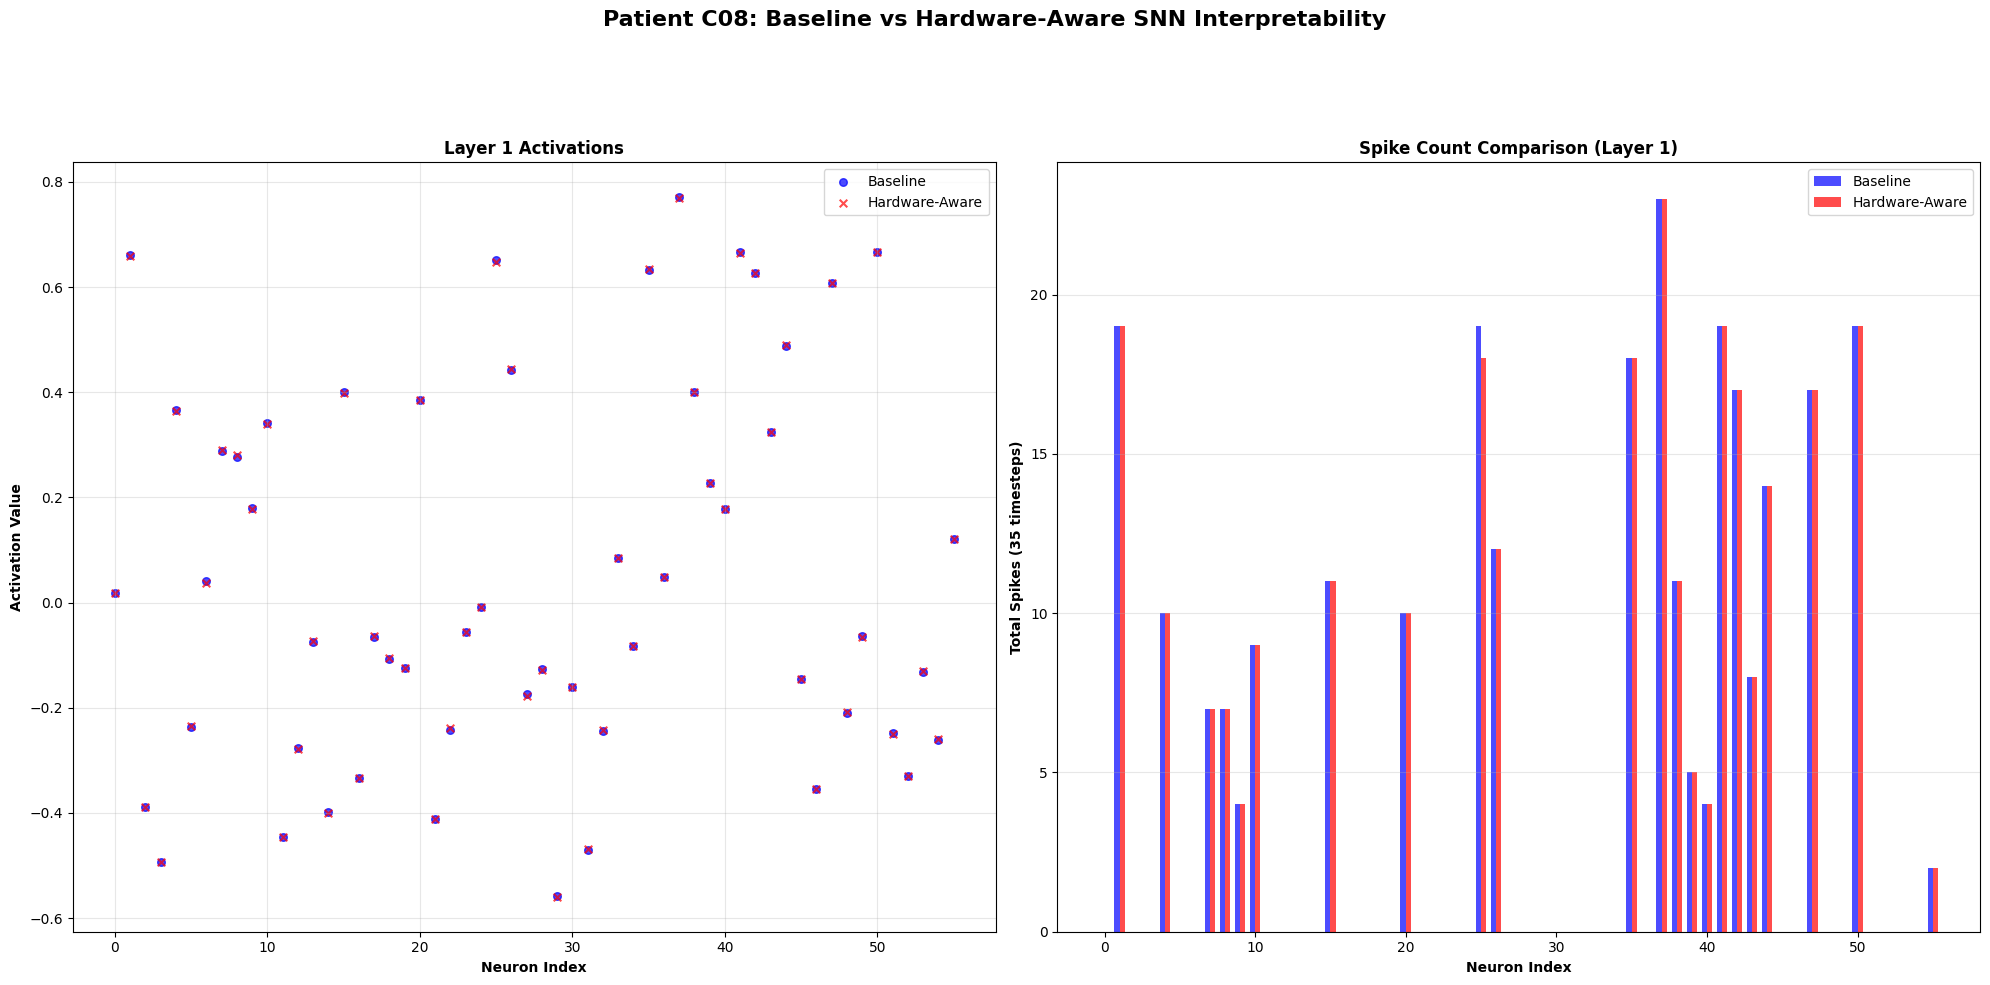

Saved interpretability figure: c08_interpretability_1x3.png


In [69]:
for idx, pid in enumerate(selected_subjects):
    patient_features = subject_data[pid]['features_avg_scaled']
    label_str = "PD" if subject_data[pid]['label'] == 1 else "Control"

    print(f"\nPatient {idx+1}/{len(selected_subjects)}: {pid} ({label_str})")

    visualize_interpretability(
        baseline_model=baseline_model,
        hardware_model=hardware_model,
        patient_features=patient_features,
        pid=pid,
        device=device,
        RESULTS_DIR=RESULTS_DIR
    )



## Comparison Visualization


In [43]:
def plot_patient_analysis(model, patient_features, feature_names, feature_labels, pid, true_label):
    """Visualize model analysis for a single patient."""
    
    label_str = "PD" if true_label == 1 else "Control"
    
    # Get data
    attribution = calculate_feature_attribution(model, patient_features)
    l1_firing, l2_firing, _ = calculate_neuron_firing(model, patient_features)
    _, ctrl_conf, pd_conf = get_prediction_confidence(model, patient_features)
    pred_str = "PD" if pd_conf > 50 else "Control"
    
    band_colors = {'delta': "#C58AFF", 'theta': "#55CBFE", 'alpha': "#6BF398",
                   'beta': "#FAA959", 'gamma': "#F95252"}
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{pid} ({label_str}) - Prediction: {pred_str}', fontsize=14, fontweight='bold')
    
    # 1. Top 15 features
    ax1 = axes[0, 0]
    sorted_idx = np.argsort(attribution)[::-1][:15]
    colors = []
    for i in sorted_idx:
        fname = feature_names[i].lower()
        color = '#666666'
        for band, c in band_colors.items():
            if band in fname:
                color = c
                break
        colors.append(color)
    
    y_pos = np.arange(15)
    ax1.barh(y_pos, attribution[sorted_idx], color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([feature_labels[i] for i in sorted_idx])
    ax1.invert_yaxis()
    ax1.set_xlabel('Attribution (%)')
    ax1.set_title('Top 15 Features')
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Layer 1 spikes
    ax2 = axes[0, 1]
    ax2.bar(range(len(l1_firing)), l1_firing, color="#55CBFE", edgecolor='black', linewidth=0.3)
    ax2.set_xlabel('Neuron Index')
    ax2.set_ylabel('Spike Count')
    ax2.set_title(f'Layer 1 Spikes (total: {l1_firing.sum():.0f})')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Layer 2 spikes
    ax3 = axes[1, 0]
    ax3.bar(range(len(l2_firing)), l2_firing, color="#55CBFE", edgecolor='black', linewidth=0.3)
    ax3.set_xlabel('Neuron Index')
    ax3.set_ylabel('Spike Count')
    ax3.set_title(f'Layer 2 Spikes (total: {l2_firing.sum():.0f})')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Output confidence
    ax4 = axes[1, 1]
    bars = ax4.bar(['Control', 'PD'], [ctrl_conf, pd_conf], color=["#55CBFE", "#FF6188"], 
                   edgecolor='black', linewidth=1.5)
    ax4.set_ylabel('Confidence (%)')
    ax4.set_ylim(0, 100)
    ax4.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    ax4.set_title('Output Confidence')
    ax4.grid(axis='y', alpha=0.3)
    
    for bar, conf in zip(bars, [ctrl_conf, pd_conf]):
        ax4.text(bar.get_x() + bar.get_width()/2, conf + 2, f'{conf:.1f}%', ha='center', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"{pid.lower()}_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"  Top feature: {feature_names[sorted_idx[0]]} ({attribution[sorted_idx[0]]:.1f}%)")
    print(f"  Confidence: Control={ctrl_conf:.1f}%, PD={pd_conf:.1f}%")

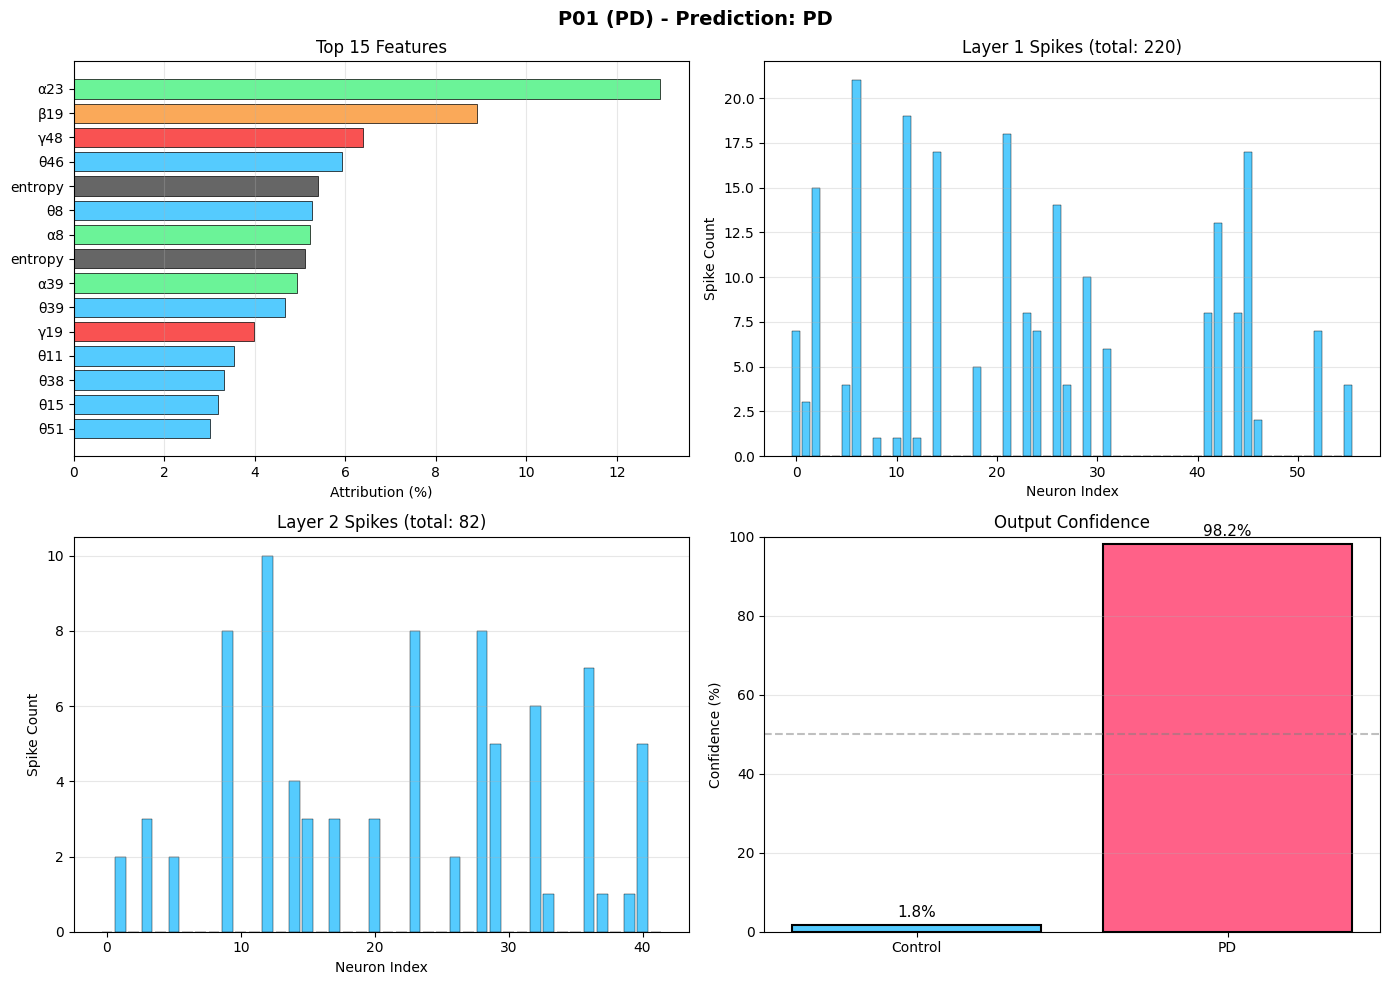

  Top feature: alpha_ch23 (13.0%)
  Confidence: Control=1.8%, PD=98.2%


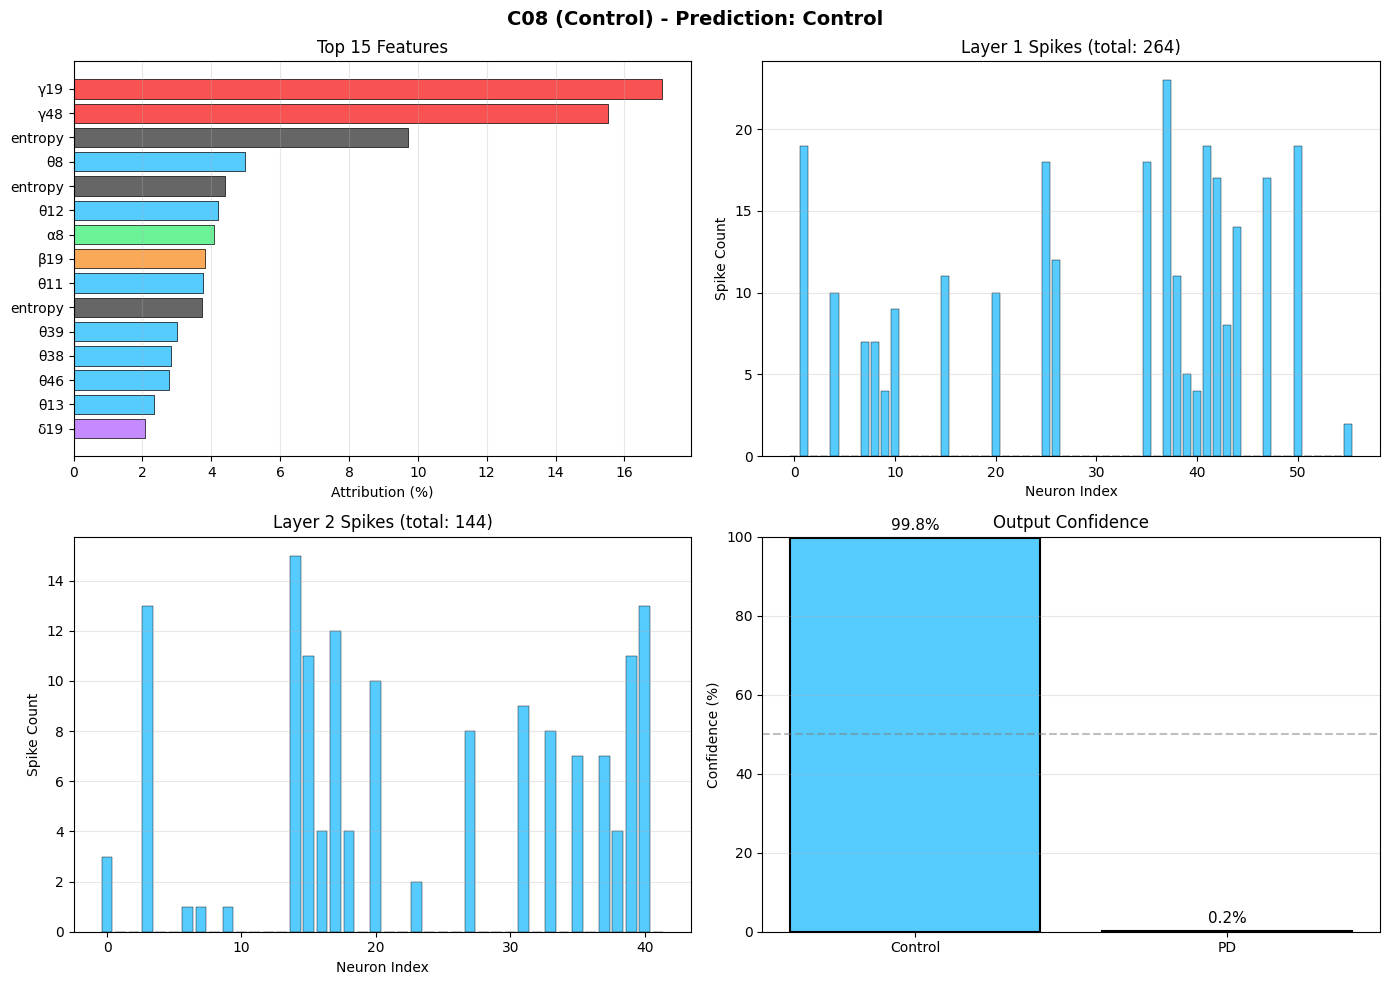

  Top feature: gamma_ch19 (17.1%)
  Confidence: Control=99.8%, PD=0.2%


In [44]:
# Analyze each patient with hardware model
for pid in selected_subjects:
    plot_patient_analysis(
        hardware_model,
        subject_data[pid]['features_avg_scaled'],
        feature_names,
        feature_labels,
        pid,
        subject_data[pid]['label']
    )

## Frequency band performance

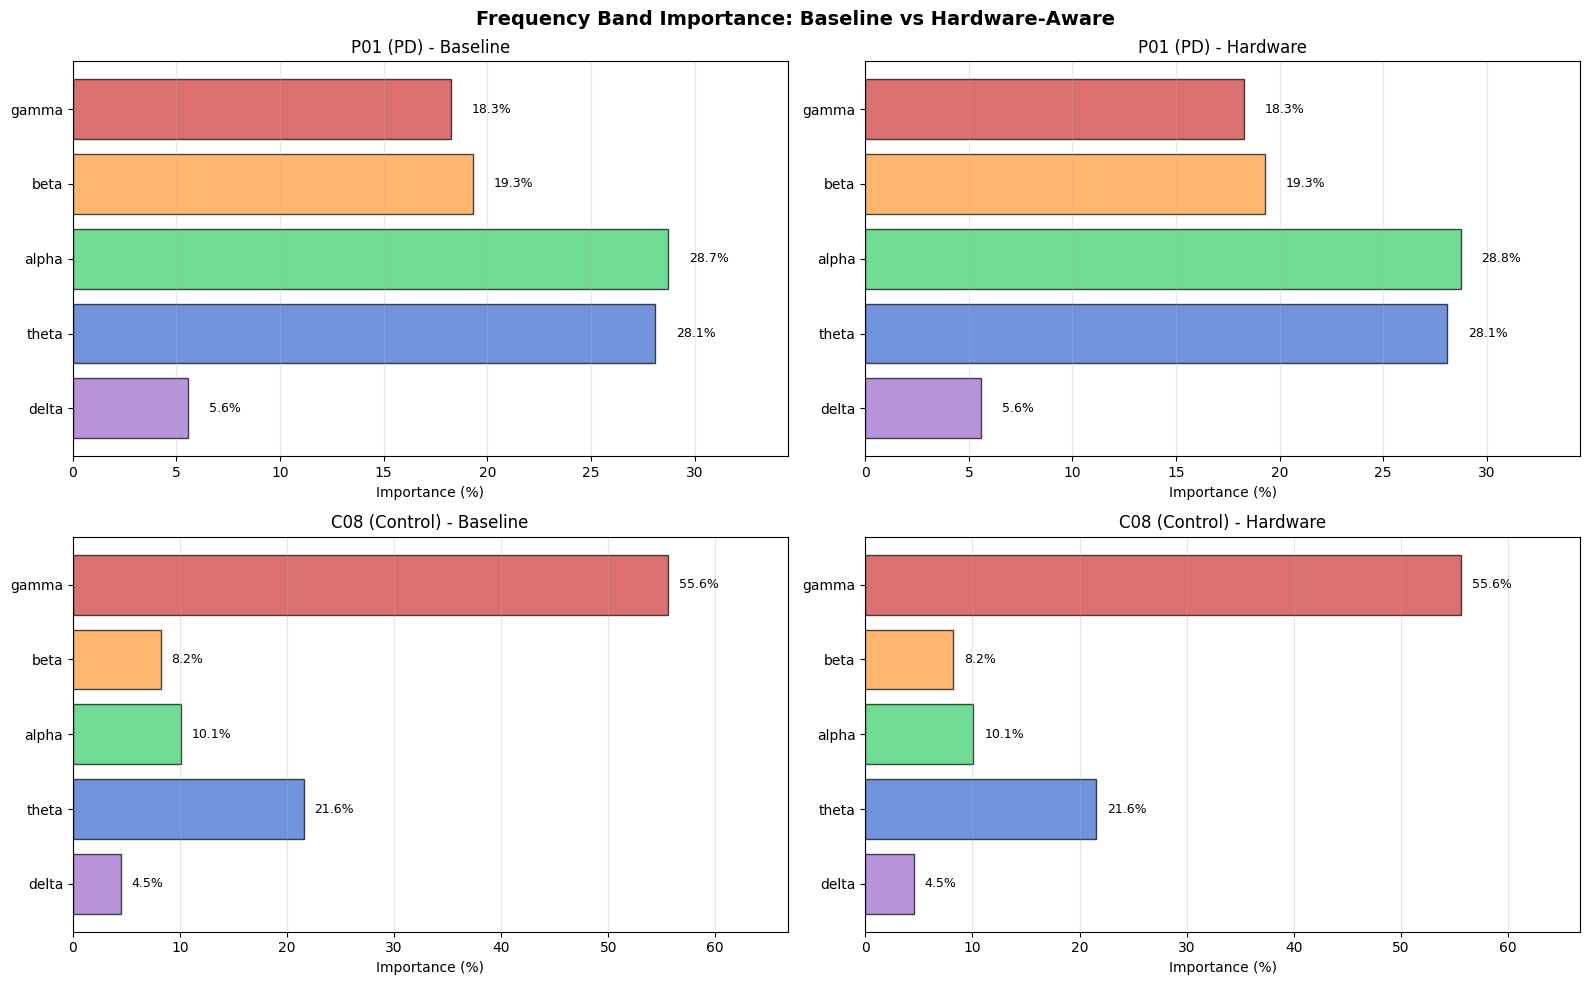

In [45]:
# Frequency band importance: Baseline vs Hardware
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Frequency Band Importance: Baseline vs Hardware-Aware', fontsize=14, fontweight='bold')

band_colors = {'delta': '#9966CC', 'theta': '#3366CC', 'alpha': '#33CC66',
               'beta': '#FF9933', 'gamma': '#CC3333'}

for row, pid in enumerate(selected_subjects):
    features = subject_data[pid]['features_avg_scaled']
    label_str = "PD" if subject_data[pid]['label'] == 1 else "Control"
    
    for col, (model_name, model) in enumerate([('Baseline', baseline_model), ('Hardware', hardware_model)]):
        ax = axes[row, col]
        importance = calculate_band_importance(model, features, feature_names)
        bands = list(importance.keys())
        values = [importance[b] for b in bands]
        colors = [band_colors[b] for b in bands]
        
        ax.barh(bands, values, color=colors, alpha=0.7, edgecolor='black')
        ax.set_xlabel('Importance (%)')
        ax.set_title(f'{pid} ({label_str}) - {model_name}')
        ax.set_xlim(0, max(values) * 1.2)
        ax.grid(axis='x', alpha=0.3)
        
        for i, val in enumerate(values):
            ax.text(val + 1, i, f'{val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "band_importance_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Summary

In [70]:
# Summary table
results = []
for pid in selected_subjects:
    features = subject_data[pid]['features_avg_scaled']
    true_label = subject_data[pid]['label']
    label_str = "PD" if true_label == 1 else "Control"
    
    for model_name, model in [('Baseline', baseline_model), ('Hardware', hardware_model)]:
        pred_class, ctrl_conf, pd_conf = get_prediction_confidence(model, features)
        pred_str = "PD" if pred_class == 1 else "Control"
        correct = pred_class == true_label
        
        band_imp = calculate_band_importance(model, features, feature_names)
        top_band = max(band_imp, key=band_imp.get)
        
        results.append({
            'Patient': pid,
            'True': label_str,
            'Model': model_name,
            'Prediction': pred_str,
            'Confidence': f"{max(ctrl_conf, pd_conf):.1f}%",
            'Correct': 'Yes' if correct else 'No',
            'Top Band': f"{top_band} ({band_imp[top_band]:.1f}%)"
        })

df = pd.DataFrame(results)
print(df.to_string(index=False))

# Accuracy summary
baseline_acc = sum(1 for r in results if r['Model']=='Baseline' and r['Correct']=='Yes') / len(selected_subjects)
hardware_acc = sum(1 for r in results if r['Model']=='Hardware' and r['Correct']=='Yes') / len(selected_subjects)
print(f"\nBaseline accuracy: {baseline_acc*100:.0f}%")
print(f"Hardware accuracy: {hardware_acc*100:.0f}%")

Patient    True    Model Prediction Confidence Correct      Top Band
    P01      PD Baseline         PD      98.2%     Yes alpha (28.7%)
    P01      PD Hardware         PD      98.2%     Yes alpha (28.8%)
    C08 Control Baseline    Control      99.8%     Yes gamma (55.6%)
    C08 Control Hardware    Control      99.8%     Yes gamma (55.6%)

Baseline accuracy: 100%
Hardware accuracy: 100%
